In [1]:
import numpy as np
import math
import random
from matplotlib import pyplot as plt
import dill

S = 4

T = 1000 # for the long term make T larger. 
#---------------------parameters for epsilon - greedy-----------------------
alpha = 0.05
eps = 0.3
gamma = 0.0
tau = 0.01

#--------threat, reward normalized here--------------
l = int(T/4)
#-----below values are the means of the probabilistic rewards/threats
pos_reward = np.array([-25,-25,25,25]) 
neg_reward = np.array([1,1, -1, -1])

#---below are values chosen to preserve the original IGT reward/frequency structure
gain_values = np.array([100,100,50,50])

#---------------function to figure out positive reward distribution-----------------

def loss_finder(pos_reward):
    # the prob of getting positive value from binary rewards
    # A: p = 0.5, B: p = 0.9, C: p = 0.5, D: p = 0.9
    loss_values = np.zeros(4)
    for i in range(4):
        if i%2 == 0:
            loss_values[i] = 2*pos_reward[i] - gain_values[i]
        else:
            loss_values[i] = 10*pos_reward[i] - 9*gain_values[i]
    return loss_values
loss_values = loss_finder(pos_reward)
#------------------------------------------------------------------------------------
def normalize(rew):
    temp = np.concatenate((np.ones(l)*rew[0], np.ones(l)*rew[1], 
                           np.ones(l)*rew[2], np.ones(l)*rew[3]))
    norm = np.std(temp, ddof=1)
    return norm


std_thr = normalize(neg_reward)
std_rew = normalize(pos_reward) 

max_reward_mean = np.max(pos_reward)/std_rew 
max_threat_mean = np.max(neg_reward)/std_thr
print(std_thr)
print(std_rew)
print(max_reward_mean)
print(max_threat_mean)
#--------------------------------------------

def linear_scalar (Q, w, epsilon):
    temp = Q[0,:]*w[0] + Q[1,:]*w[1]
    if np.random.uniform(0,1) < epsilon:
        action = np.random.randint(0,4)
    else:
        action = np.random.choice(np.array(np.where(temp == np.amax(temp))).flatten())
    return action
# multiply might be in the psychiatry literature
# 
def softmax_one (Q, w, tau):
    temp = (Q[0,:]*w[0] + Q[1,:]*w[1])/tau 
    ex = np.exp(temp - np.max(temp))
    weights = ex/np.sum(ex)
    #print(weights)
    population = np.arange(np.size(Q,1))
    
    action = random.choices(population, weights)
    return action[0]

def softmax_two (Q, w, tau):
    ex_zero =  np.exp((Q[0,:] - np.max(Q[0,:]))/tau)
    weights_zero = ex_zero/np.sum(ex_zero)
    ex_one =  np.exp((Q[1,:] - np.max(Q[1,:]))/tau)
    weights_one = ex_one/np.sum(ex_zero)
    
    weights = w[0]*weights_zero + w[1]*weights_one
    #print('-----------')
    #print(w)
    #print(weights_zero, weights_one)
    #print(weights)
    population = np.arange(np.size(Q,1))

    action = choices(population, weights)
    
    return action[0]
    
def update(curr_action, Q, next_action, r, obj, alpha):
    predict = Q[obj, curr_action]
    target = r+ gamma*Q[obj, next_action]
    Q[obj, curr_action] = Q[obj, curr_action]*(1-alpha) + alpha*target

#---------THIS IS WHERE REWARDS ARE CHANGED----------------
# DEFAULT IS {-25,-25,25,25}
# 1) {-50,-25,25,25} looks linear
# 2) {-50,-5, 20, 70 } also looks linear
# 3) {-50,-5, 20, 70} and {0,0,-1,-3} looks almos linear. 
def step(curr_action):
    # actions {0,1,2,3} correspond to decks {A,B,C,D}
    weights = np.array([[0.5,0.5],
                        [0.9,0.1],
                        [0.5,0.5],
                        [0.9,0.1]])
    reward = random.choices([gain_values[curr_action], loss_values[curr_action]], weights[curr_action])
    threat = neg_reward[curr_action]
    reward/=std_rew
    threat/=std_thr
    return reward[0], threat

#----------------TRAINING STARTS HERE --------------------
# partition parameter
p = 0.02
W = int(1/p) + 1

Q = np.zeros((S,2,4,W))

reward_regret = np.zeros((S,T,W))
threat_regret = np.zeros((S,T,W))
actions = np.zeros((S,4,W))



for w in range(W):
    weight = [w*p, 1.0-w*p]
    #print(weight)
    for s in range(S):
        for t in range(T):
            curr_action = softmax_one(Q[s,:,:,w], weight, tau)
            #print("action = ", curr_action)
            actions[s,curr_action,w]+=1
            reward, threat = step(curr_action)
            
            #print("reward = ", np.round(reward,3))
            #print("threat = ", np.round(threat,3))
            next_action = linear_scalar(Q[s,:,:,w], weight, 0.0)
            
            update(curr_action, Q[s,:,:,w], next_action, reward, 0, alpha)
            update(curr_action, Q[s,:,:,w], next_action, threat, 1, alpha)
            #print(np.round(Q[s,:,:,w],3))
            reward_regret[s,t,w] = max_reward_mean - reward
           
            threat_regret[s,t,w] = max_threat_mean - threat
        


1.0005003753127737
25.012509382819342
0.999499874937461
0.999499874937461


In [2]:
print(loss_values)

[ -150. -1150.     0.  -200.]


In [3]:
# only picking deck A
from colorama import init
from termcolor import colored
import dill
dill.dump_session('saved.db')

rew = pos_reward/std_rew
regret = max_reward_mean - rew
print("pure reward regrets after scaling = ", regret)

thr = neg_reward/std_thr
thr_regret = max_threat_mean - thr
print("pure threat regret after scaling = ", thr_regret)
print("-------------------------------------------------------------------------------")

# pos_reward = np.array([15,12,10,25]) 
# neg_reward = np.array([0,-18,-12,-5])

print("positive rewards from decks = ", gain_values, colored(" --- kept same as the original IGT", 'red'))
print("negative rewards from decks = ", loss_values, colored("--- calculated after fixing the means below", 'red'))
print("means of rewards combining above two with IGT reward probs : ", pos_reward)

pure reward regrets after scaling =  [1.99899975 1.99899975 0.         0.        ]
pure threat regret after scaling =  [0.         0.         1.99899975 1.99899975]
-------------------------------------------------------------------------------
positive rewards from decks =  [100 100  50  50]  --- kept same as the original IGT
negative rewards from decks =  [ -150. -1150.     0.  -200.] --- calculated after fixing the means below
means of rewards combining above two with IGT reward probs :  [-25 -25  25  25]


In [4]:
from colorama import init
from termcolor import colored

print(colored("Learned Q-table = ", 'red'))
print(np.mean(Q[:,:,:,0],0))# w = 1 
print(colored("Optimal values that to be learned = :", 'red'))
print(np.stack((pos_reward/std_rew, neg_reward.T/std_thr)))
# threat Q-values are learned precisely. This is most likely due to deterministic threats. 

Learned Q-table = 
[[-0.30884503  0.044975    0.          0.        ]
 [ 0.49974994  0.49974994 -0.01249375  0.        ]]
Optimal values that to be learned = :
[[-0.99949987 -0.99949987  0.99949987  0.99949987]
 [ 0.99949987  0.99949987 -0.99949987 -0.99949987]]


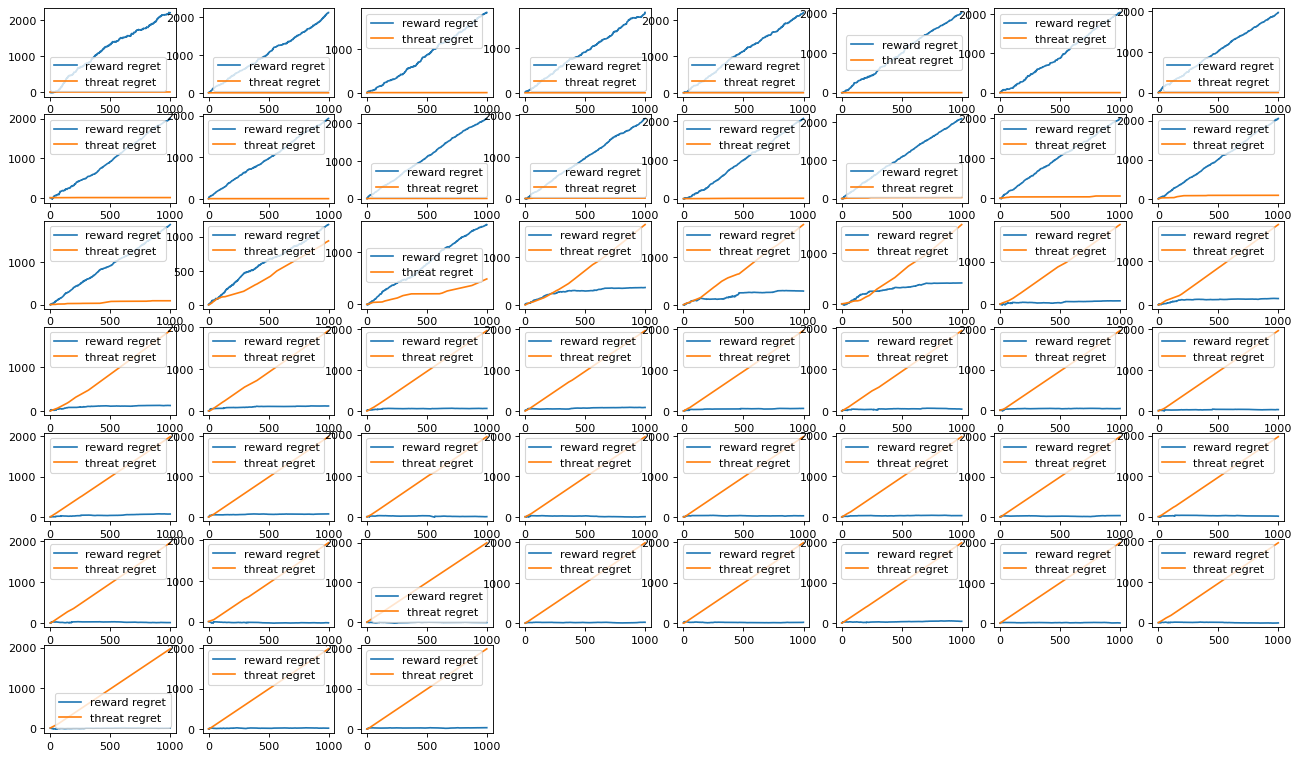

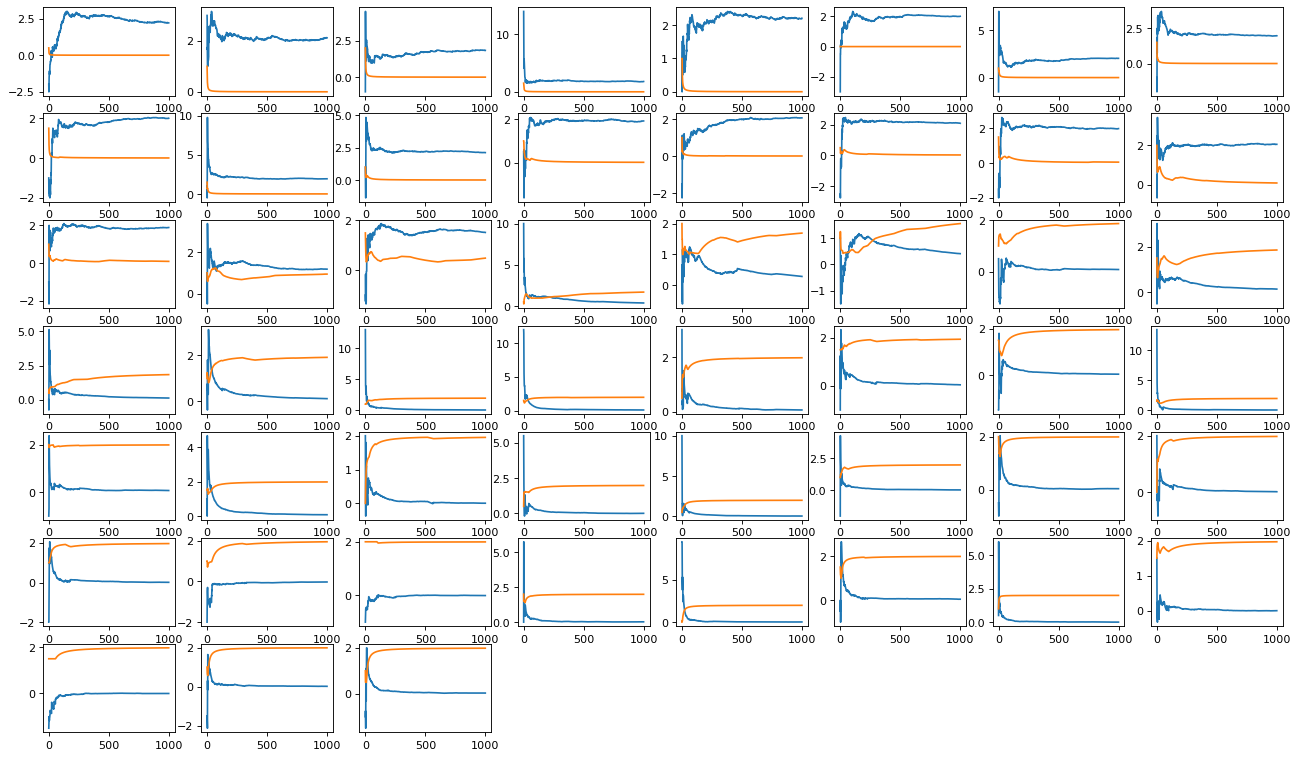

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(20,12), dpi=80)

x = np.arange(T)
plt.figure(1)
cum_rew_regret = np.zeros((T,W))
cum_thr_regret = np.zeros((T,W))
for w in range(W):
    cum_rew_regret[:,w] = np.cumsum(np.mean(reward_regret[:,:,w], 0))
    cum_thr_regret[:,w] = np.cumsum(np.mean(threat_regret[:,:,w], 0))
    plt.subplot(7,8,w+1)
    plt.plot(x, cum_rew_regret[:,w], x, cum_thr_regret[:,w])
    plt.legend(['reward regret', 'threat regret'])
    #print(cum_rew_regret)
#now plot time-averaged regrets

for t in range(T):
    cum_rew_regret[t,:]/=(t+1)
    cum_thr_regret[t,:]/=(t+1)

figure(figsize=(20,12), dpi=80)
plt.figure(2)
for w in range(W):
    plt.subplot(7,8,w+1)
    plt.plot(x, cum_rew_regret[:,w], x, cum_thr_regret[:,w] )

In [6]:
# some debugging
# debugging a bit here\n",
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(16, 10), dpi=80)
for w in range(W):
    print(w*p, ": ", np.round(np.mean(actions[:,:,w], 0)/T,2))
#     print(np.round(np.mean(Q[:,0,:,w]*w+Q[:,1,:,w]*(W-w), axis=(0,1)),2))


0.0 :  [0.5 0.5 0.  0. ]
0.02 :  [0.75 0.25 0.   0.  ]
0.04 :  [0.75 0.25 0.   0.  ]
0.06 :  [0.75 0.25 0.   0.  ]
0.08 :  [0.75 0.25 0.   0.  ]
0.1 :  [0.87 0.13 0.   0.  ]
0.12 :  [0.85 0.15 0.   0.  ]
0.14 :  [0.93 0.07 0.   0.  ]
0.16 :  [0.92 0.08 0.   0.  ]
0.18 :  [1. 0. 0. 0.]
0.2 :  [0.99 0.01 0.   0.  ]
0.22 :  [0.97 0.03 0.   0.  ]
0.24 :  [0.92 0.08 0.   0.  ]
0.26 :  [0.96 0.02 0.01 0.01]
0.28 :  [0.94 0.03 0.01 0.02]
0.3 :  [0.94 0.02 0.02 0.02]
0.32 :  [0.93 0.02 0.04 0.01]
0.34 :  [0.52 0.01 0.41 0.06]
0.36 :  [0.73 0.02 0.21 0.03]
0.38 :  [0.15 0.   0.77 0.08]
0.4 :  [0.12 0.03 0.69 0.16]
0.42 :  [0.18 0.05 0.75 0.02]
0.44 :  [0.03 0.03 0.84 0.1 ]
0.46 :  [0.07 0.01 0.84 0.08]
0.48 :  [0.07 0.02 0.84 0.08]
0.5 :  [0.04 0.01 0.93 0.03]
0.52 :  [0.01 0.01 0.96 0.02]
0.54 :  [0.01 0.   0.97 0.01]
0.56 :  [0.   0.01 0.96 0.03]
0.58 :  [0.01 0.02 0.94 0.02]
0.6 :  [0.   0.02 0.97 0.01]
0.62 :  [0.01 0.01 0.98 0.  ]
0.64 :  [0.   0.   0.95 0.05]
0.66 :  [0.01 0.   0.99 0.  ]

<Figure size 1280x800 with 0 Axes>

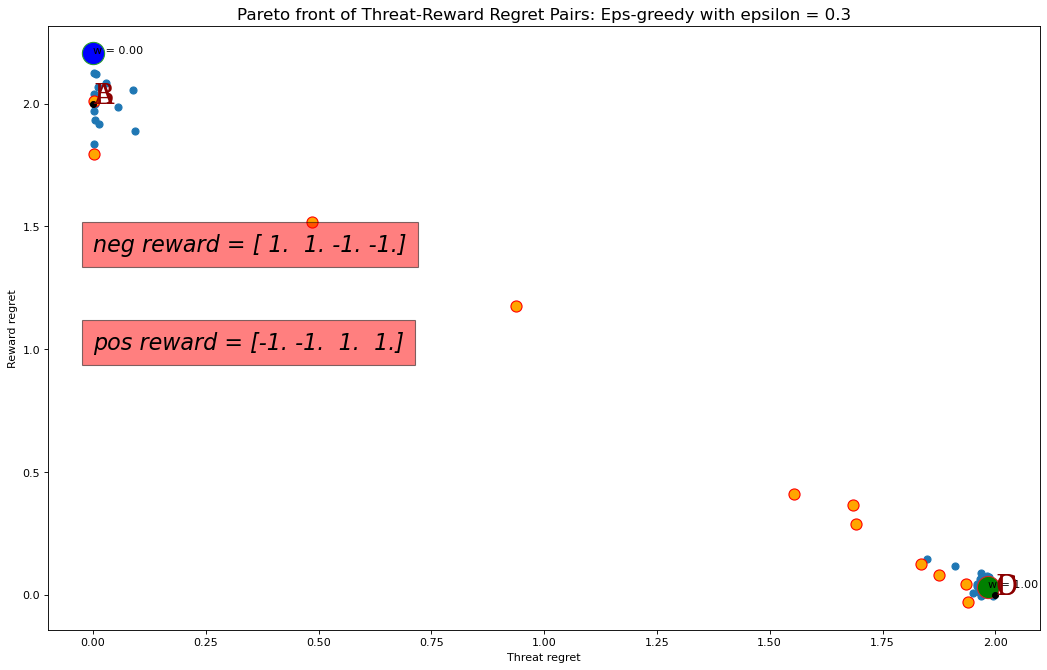

In [7]:
# plotting asymptotics against the weight.
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(16, 10), dpi=80)
np.shape(reward_regret)
y = cum_rew_regret[T-1,:] # make T larger average over last few time steps
x = cum_thr_regret[T-1,:]
# print(x)
# print(y)
annotations=[]

for w in range(W):
    f = format(w*p, ".2f")
    annotations = np.append(annotations,"w = "+str(f) )
plt.scatter(x,y, s=40)
plt.xlabel("Threat regret")
plt.ylabel("Reward regret")
plt.title("Pareto front of Threat-Reward Regret Pairs: Eps-greedy with epsilon = " +str(eps),fontsize=15)
# for i, label in enumerate(annotations):
#     plt.annotate(label, (x[i], y[i]))
# print(annotations)

rewards = np.round(pos_reward/std_rew, 2)
threats = np.round(neg_reward/std_thr, 2)

plt.text(0.0,1.0, 'pos reward = ' + str(rewards), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10},fontsize=20)
plt.text(0.0,1.4, 'neg reward = ' + str(threats), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10},fontsize=20)


# Pareto front plotter
# returns true only if (a,b) is not Pareto dominated by (a1,b1)
def isPareto(a,b,a1,b1):
    if a1 > a:
        return True
    elif b1 > b:
        return True
    else:
        return False
#print(isPareto(0.2,0.2,0.2,0.2))

n = np.size(x)
for i in range(n):
    count = 0
    for j in range(n):
        if  isPareto(x[i], y[i], x[j], y[j]):
            count+=1
    #print(x[i], y[i])
    #print(count)
    if count==n-1:
#         print(x[i],y[i])
        plt.plot(x[i], y[i],marker="o",markersize=10, markeredgecolor="red",
            markerfacecolor="orange")
#         plt.annotate(x[i], y[i])
plt.plot(x[0], y[0], marker = "o", markersize = 20, markerfacecolor = "blue")
plt.plot(x[n-1], y[n-1], marker = "o", markersize = 20, markerfacecolor = "green")

plt.annotate(annotations[0], (x[0], y[0]))  
plt.annotate(annotations[n-1], (x[n-1], y[n-1]))    
plt.plot(thr_regret,regret, "kx", marker = "o", markersize = 5, markerfacecolor = "black")
thr_regret = np.round(thr_regret, 2)
regret = np.round(regret, 2)
lbls = ['A ', 'B', 'C', 'D']
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 25,
        }
for i in range(4):
    plt.text(thr_regret[i], regret[i], lbls[i], fontdict = font )
plt.show()

In [8]:
# Pareto front plotter
# Decides if (a,b) Pareto Dominates (a1,b1)
def isPareto(a,b,a1,b1):
    if a>a1:
        return False
    elif b>b1:
        return False
    else:
        return True
